## Implement of a curvature

Here we compute the transport map $\mathbf{O}_{ij}:= \mathscr{F}^T_{v \unlhd e}\mathscr{F}_{u \unlhd e}$ according to  https://arxiv.org/pdf/2206.08702.pdf and https://arxiv.org/pdf/1102.0075.pdf

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd

In [2]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 



def find_basis(point_cloud, x, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.2 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 5 * np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q], full_matrices = False)
        O_i = U[:, :dim]
        O.append(O_i)
        
    return epsilon_neighborhood, tau_neighborhood, tau_epsilon_neighborhood, O



## Use triangle

In [3]:
def compute_curvature_v2(point_cloud, query_point, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    
    ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(point_cloud, query_point, epsilon_PCA = epsilon_PCA,
                                                                    dim = dim, tau_ratio = tau_ratio)

    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), dim, dim))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []
    """
    O_init = O[0]
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            O_fin = O_init @ transport_maps[0, i] @ transport_maps[i, j] @ transport_maps[j, 0]
            v_init = O_init.T[0]
            v_fin = O_fin.T[0]
            
            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
            angle = np.arccos(cosin)
            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            
            #tensor = angle / area
            tensor = (2 * np.pi - angle) / area 
            
            tensor_av.append(tensor)
            
            #tensor = angle / area                                  
    """
    O_init = O[0]
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            O_fin = O_init @ transport_maps[0, i] @ transport_maps[i, j] @ transport_maps[j, 0]
            v_init_1 = O_init.T[0]
            v_fin_1 = O_fin.T[0]
            
            v_init_2 = O_init.T[1]
            v_fin_2 = O_fin.T[1]
            
            cosin_1 = (v_init_1 @ v_fin_1.T) / (np.linalg.norm(v_init_1) * np.linalg.norm(v_fin_1))
            angle_1 = np.arccos(cosin_1)
            
            cosin_2 = (v_init_2 @ v_fin_2.T) / (np.linalg.norm(v_init_2) * np.linalg.norm(v_fin_2))
            angle_2 = np.arccos(cosin_2)
            
            angle = (angle_1 + angle_2) / 2
            
            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            
            #tensor = angle / area
            tensor = (2 * np.pi - angle) / area 
            
            tensor_av.append(tensor)
    
    
    tensor_av = np.exp(sum(tensor_av)/len(tensor_av) * 0.0001)
         
    return transport_maps, tensor_av 
 

In [4]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return np.column_stack((rx, ry, rz))

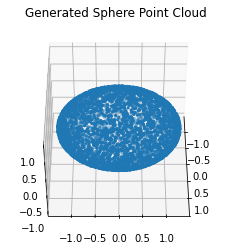

In [5]:
ellipsoid = generate_ellipsoid_cloud(0.9, 1.3, 0.9)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ellipsoid[:, 0], ellipsoid[:, 1], ellipsoid[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(45, 0)
plt.show()

In [6]:
ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(ellipsoid, np.expand_dims(ellipsoid[10], axis = 0) , epsilon_PCA = 0.1, tau_ratio = 1)

In [7]:
from numpy import savetxt
savetxt('ellipsoid_9_13_9.csv', ellipsoid, delimiter=',')

In [ ]:
num_eval = int(len(ellipsoid)/5)

curvature = []
for i in tqdm(range(num_eval)):
    a, b = compute_curvature_v2(ellipsoid, np.expand_dims(ellipsoid[i], axis=0), epsilon_PCA = 0.1, tau_ratio =2)
    curvature.append(b)


  0%|          | 0/1000 [00:00<?, ?it/s]

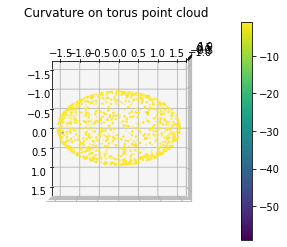

In [18]:
v = np.array(curvature).T
# Visualize the point cloud
cc = - v
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = cc)
ax.set_title("Curvature on torus point cloud")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

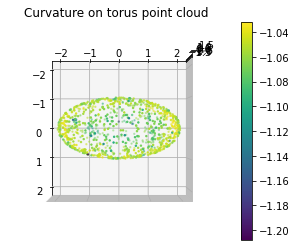

In [27]:
v = np.array(curvature).T
# Visualize the point cloud
cc = - v
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = cc)
ax.set_title("Curvature on torus point cloud")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()